In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy import interpolate
import pickle

import Functions

In [5]:
Path0 = '/global/homes/l/lianming/data/'
Path1 = '/global/homes/l/lianming/data/GSN_IDEAL_zALL_p1day'
Path2 = '/global/homes/l/lianming/data/GSN_IDEAL_zALL_36min'
Path3 = '/global/homes/l/lianming/data/GSN_IDEAL_z02'
PathTest = '/global/homes/l/lianming/data/For_Test'

In [1]:
Path = PathTest
PathInterp = os.path.join(Path0, 'Test_Interp1/')

NameError: name 'PathTest' is not defined

In [7]:
PathsDict = Functions.GetEventPaths(Path)
EventNames = list(PathsDict.keys())

In [8]:
#Parameter setting

EventNames = EventNames

Bands = ['u ', 'g ', 'r ', 'i ', 'z ', 'Y ']

StartFile = None
EndFile = None

StartObject = None
EndObject = None

In [10]:
#Result structure ObjInterps[Band][ObjNo], save a file for eath event.
os.mkdir(PathInterp)
os.chdir(PathInterp)

with open('EventName.npy', 'wb') as f:
    np.save(f, EventNames)

# np.save('/EventName.npy', EventNames)

for EventName in EventNames:

    print('Processing {:<25}'.format(EventName+':'), end='')
    start = time.time()

    ObjInterps = {'u': [], 'g': [], 'r': [], 'i': [], 'z': [], 'Y': []}
    TimeRange = {'u': [], 'g': [], 'r': [], 'i': [], 'z': [], 'Y': []}

    EventPath = PathsDict[EventName]
    FileNames = os.listdir(EventPath)
    FileNames.sort()
    
    BadObjNo = 0

    for FileName in FileNames[StartFile: EndFile]:
        
        Ind = FileName.find('HEAD')
        
        if Ind > -1:

            print('|', end='')
            
            FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'
            
            HeadFilePath = os.path.join(EventPath, FileName)
            PhotFilePath = os.path.join(EventPath, FileNamePHOT)
            Data = Functions.read_snana_fits(HeadFilePath, PhotFilePath)
            
            for II, Obj in enumerate(Data[StartObject: EndObject]):
                
                for Band in Bands:

                    Mask = Obj['BAND']==Band
                    MaskMag99 = Obj['SIM_MAGOBS'][Mask]!=99
                    
                    if sum(MaskMag99)<2:
                        ObjInterps[Band[0]].append([])
                        TimeRange[Band[0]].append([0,0])
                        
                        BadObjNo += 1
                        
#                         print('{} File {} Obj {} Band {}, effective points are {}.'.format(EventName,
#                                                                                            FileName[FileName.find('HEAD')-5:FileName.find('HEAD')-1],
#                                                                                            II,Band[0],sum(MaskMag99)))
                    else:
                        fobject  = interpolate.interp1d(Obj['MJD'][Mask][MaskMag99], Obj['SIM_MAGOBS'][Mask][MaskMag99])
                        ObjInterps[Band[0]].append(fobject)
                        TimeRange[Band[0]].append([Obj['MJD'][Mask][MaskMag99][0], Obj['MJD'][Mask][MaskMag99][-1]])
        
    with open(EventName+'_Interp.pkl', 'wb') as f:
        pickle.dump(ObjInterps, f)
        pickle.dump(TimeRange, f )    
            
    end = time.time()
    
    if BadObjNo>0:
        print('\t time spent: {0:6.3f} s'.format(end-start), end='\t')
        print('{} bad objects found.'.format(BadObjNo))
    else:
        print('\t time spent: {0:6.3f} s'.format(end-start))
    
print('Finish!')    

Processing KN_B19:                  ||||||||||||||||||||	 time spent: 27.790 s
Processing TDE:                     ||||||||||||||||||||	 time spent: 28.296 s
Processing uLens-Single-GenLens:    ||||||||||||||||||||	 time spent: 17.728 s
Processing uLens-Single_PyLIMA:     ||||||||||||||||||||	 time spent: 14.824 s
Finish!


In [127]:
with open(EventName+'_Interp.pkl', 'wb') as f:
    pickle.dump(ObjInterps, f)
    pickle.dump(TimeRange, f ) 

In [16]:
def CalculateMap(PathInterp, EventName, Band1, Band2, dT1, dT2, PointsPDay = 50, Thr=27.5, Save=0, TargetFolder='MapData'):    
    
    FilePath = os.path.join(PathInterp, EventName+'_Interp.pkl')
    
    with open(FilePath, 'rb') as f:
        Interp_load = pickle.load(f)
        TimeRange_load = pickle.load(f)    

    dMag = []
    Color = []

    for II in range(len(Interp_load[Band1])):
        
        if Interp_load[Band1][II]==[] or Interp_load[Band2][II]==[]:
            continue
        
        if II%5000 == 4999:
            print('|')
        elif II%50 == 49:
            print('|', end='' )

        TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
        TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )

        TimeRange = TimeRangeEnd - TimeRangeStart
        SampleNo = np.int(PointsPDay*TimeRange)
        
        XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart

        Mag1 = Interp_load[Band1][II](XX)
        Mag2 = Interp_load[Band2][II](XX+dT1/1440)
        Mag12 = Interp_load[Band1][II](XX+dT2/1440)

        Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)

        dMag.extend(Mag1[Mask] - Mag12[Mask])
        Color.extend(Mag1[Mask] - Mag2[Mask])
        
    data = np.array([dMag, Color])
    
    if Save == 1:
    
        TargetPath = os.path.join(Path0, TargetFolder)                            
        if not os.path.isdir(TargetPath):
            os.mkdir(TargetPath)
        os.chdir(TargetPath)

        Ind1 = PathInterp.rfind('/')
        Ind2 = PathInterp.rfind('_')
        
        FileName = '{}{}_dT1_{}_dT2_{}_PPD{}_Thr{}_{}_Source_{}.npy'.format(Band1, Band2, dT1, dT2, PointsPDay, Thr, EventName, PathInterp[Ind1+1:Ind2])
        np.save(FileName, data)
        
        print('The data is saved at {} as {}.'.format(TargetPath, FileName))
    
    print('Finish!')
        
    return data

In [ ]:
global/homes/l/lianming/data/2Day_Interp/SNIa-SALT2_Interp.pkl

In [3]:
time1 = time.time()
with open('/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp/SNIa-SALT2_Interp.pkl', 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)
    
time.time() - time1

7.193050146102905

In [4]:
TimeRange_load['g'][0]

[53082.0, 53400.0]

40000
40000


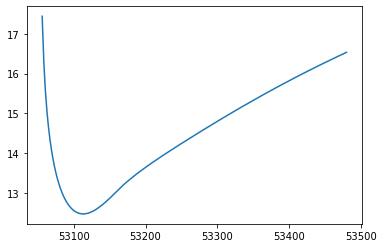

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp/SLSN-I_Interp.pkl', 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)
    
print(len(Interp_load['g']))
print(len(TimeRange_load['g']))

xx = np.arange( TimeRange_load['g'][-1][0], TimeRange_load['g'][-1][1], 0.1)

plt.plot(xx, Interp_load['g'][-1](xx))

40000
40000


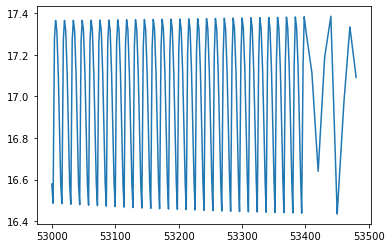

In [16]:
PathInterp = '/global/cscratch1/sd/lianming/data/2Day_Interp'
EventName = 'RRL'
FilePath = os.path.join(PathInterp, EventName+'_Interp.pkl')

with open(FilePath, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)
    
print(len(Interp_load['g']))
print(len(TimeRange_load['g']))

xx = np.arange( TimeRange_load['g'][-1][0], TimeRange_load['g'][-1][1], 0.1)

plt.plot(xx, Interp_load['g'][-1](xx))

40000
40000


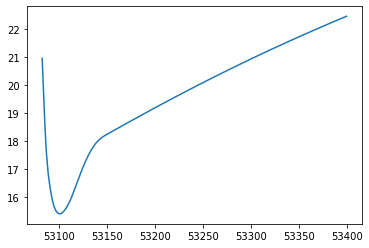

In [58]:
time1 = time.time()

data = []

for ii in range(10000):

    XX = np.random.rand(1000)*300 + TimeRange_load['g'][0][0]
    YY = Interp_load['g'][0](XX)

    data.extend(YY)

time.time() - time1

16.377168655395508

In [54]:
time1 = time.time()

data = np.array([])

for ii in range(10000):

    XX = np.random.rand(1000)*300 + TimeRange_load['g'][0][0]
    YY = Interp_load['g'][0](XX)

    data[ii*1000: (ii+1)*1000] = YY

time.time() - time1

11.063381433486938

In [47]:
ii

999

In [34]:
data = np.array([])

In [26]:
XX = np.random.rand(10)*300 + TimeRange_load['g'][0][0]
YY = Interp_load['g'][0](XX)

In [27]:
YY

array([20.3696991 , 21.89404708, 19.66501176, 21.94445486, 19.23309072,
       20.99307521, 19.92468273, 20.90445018, 21.88688111, 18.32022876])

In [38]:
%timeit np.append(data, YY)

4.71 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
%timeit np.concatenate([data, YY])

1.8 µs ± 629 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [32]:
EventNames = ['AGN', 'EB', 'KN_B19', 'MIRA', 'RRL', 'TDE', 'uLens-Binary']
PathInterpP1Day = '/global/homes/l/lianming/data/P1Day_Interp'
PathInterp2Day = '/global/homes/l/lianming/data/2Day_Interp'

#Parameter setting
PathInterp = PathInterp2Day
EventName = 'SNIa-SALT2'

Band1 = 'g'
Band2 = 'i'

dT1 = 60 #Time interval between different bands. 
dT2 = 480 #Time interval between the same band.

PointsPDay=0.01
TargetFolder='2Day_Diagram'

In [33]:
data = CalculateMap(PathInterp=PathInterp, EventName=EventName, Band1=Band1, Band2=Band2, dT1=dT1, dT2=dT2, PointsPDay=PointsPDay, TargetFolder=TargetFolder);

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finish!


In [34]:
data.shape

(2, 119997)

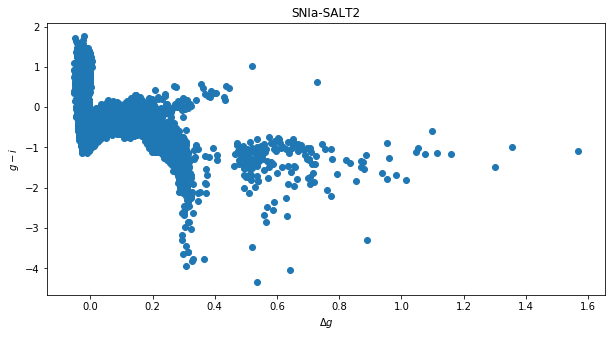

In [35]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

plt.scatter(data[0], data[1])

In [22]:
data[0]

array([-0.00352989, -0.00185122, -0.00178317, ..., -0.00478099,
       -0.00157744,  0.02768377])

In [152]:
for EventName in EventNames:
    CalculateMap(PathInterp=PathInterp, EventName=EventName, Band1=Band1, Band2=Band2, dT1=dT1, dT2=dT2, PointsPDay=PointsPDay, TargetFolder=TargetFolder);

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!
|||||||||||||||||||||||||||||||||||||||||||||||||||||Finish!


In [149]:
EventNames = list(Functions.GetEventPaths(Path1).keys())

In [150]:
EventNames

['AGN',
 'CART',
 'EB',
 'ILOT',
 'KN_B19',
 'KN_K17',
 'MIRA',
 'Mdwarf',
 'PISN',
 'RRL',
 'SLSN-I',
 'SNII-NMF',
 'SNII-Templates',
 'SNIIn',
 'SNIa-91bg',
 'SNIa-SALT2',
 'SNIax',
 'SNIbc-MOSFIT',
 'SNIbc-Templates',
 'TDE',
 'V19_CC+HostXT',
 'uLens-Binary',
 'uLens-Single-GenLens',
 'uLens-Single_PyLIMA']

In [3]:
from astroML import plotting

([<matplotlib.lines.Line2D at 0x2aab8c963a50>],
 <matplotlib.contour.QuadContourSet at 0x2aab9c1d2510>)

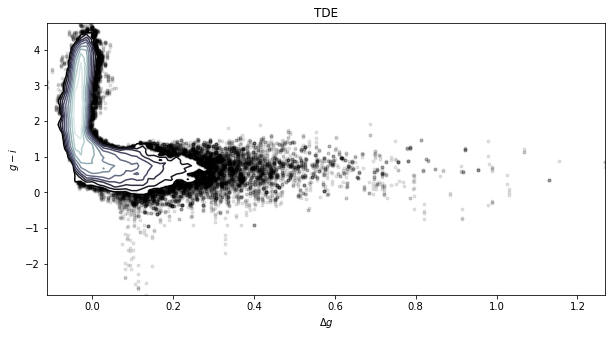

In [30]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

plotting.scatter_contour(KN[0], KN[1], 
                         threshold=50,log_counts=True, 
                         histogram2d_args=dict(bins=(100,100)), filled_contour=False,
                         plot_args=dict(marker='.', linestyle='none', color='black', alpha=0.1),
                         contour_args=dict(alpha=1, cmap='bone'))

([<matplotlib.lines.Line2D at 0x2aab9d582f10>],
 <matplotlib.contour.QuadContourSet at 0x2aab8c98b390>)

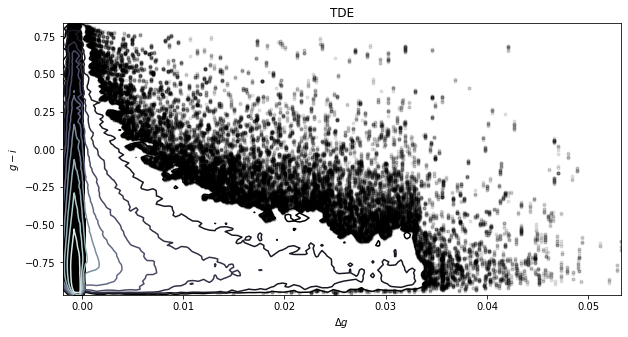

In [34]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

plotting.scatter_contour(TDE[0], TDE[1], 
                         threshold=50,log_counts=True, 
                         histogram2d_args=dict(bins=(100,100)), filled_contour=False,
                         plot_args=dict(marker='.', linestyle='none', color='black', alpha=0.1),
                         contour_args=dict(alpha=1, cmap='bone'))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

plotting.scatter_contour(dMag, Color, 
                         threshold=50,log_counts=True, 
                         histogram2d_args=dict(bins=(100,100)), filled_contour=False,
                         plot_args=dict(marker='.', linestyle='none', color='black', alpha=0.1),
                         contour_args=dict(alpha=1, cmap='bone'))

In [22]:
EventNames = ['SNIa-SALT2', 'TDE', 'KN_B19']
PathInterpP1Day = '/global/homes/l/lianming/data/P1Day_Interp'
PathInterp2Day = '/global/homes/l/lianming/data/2Day_Interp'

#Parameter setting
PathInterp = PathInterp2Day
EventName = 'SNIa-SALT2'

Band1 = 'g'
Band2 = 'i'

dT2 = 30 #Time interval between the same band.
dT1 = 5 #Time interval between different bands.

PointsPDay = 5

Path = os.path.join(PathInterp, EventName+'_Interp.pkl')

with open(Path, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)    

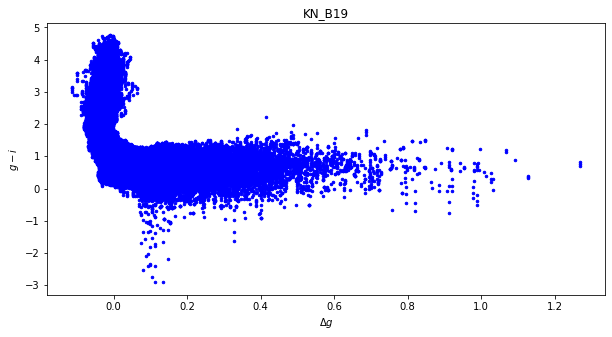

In [138]:
Thr = 30

fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

for II in range(len(Interp_load[Band1])):
    
    TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
    TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )
    
    TimeRange = TimeRangeEnd - TimeRangeStart
    SampleNo = np.int(PointsPDay*TimeRange)
    
    XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
    
    Mag1 = Interp_load[Band1][II](XX)
    Mag2 = Interp_load[Band2][II](XX+dT1/1440)
    Mag12 = Interp_load[Band1][II](XX+dT2/1440)
    
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)
    
    ax.plot(Mag1[Mask] - Mag12[Mask], Mag1[Mask] - Mag2[Mask], '.', c = 'b', markersize=5)
    
    

In [9]:
EventNames = ['SNIa-SALT2', 'TDE', 'KN_B19']
PathInterpP1Day = '/global/homes/l/lianming/data/P1Day_Interp'
PathInterp2Day = '/global/homes/l/lianming/data/2Day_Interp'



#Parameter setting
PathInterp = PathInterp2Day
EventName = 'SNIa-SALT2'

Band1 = 'g'
Band2 = 'i'

dT2 = 450 #Time interval between the same band.
dT1 = 60 #Time interval between different bands.

PointsPDay = 5



Path = os.path.join(PathInterp, EventName+'_Interp.pkl')

with open(Path, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)    

In [12]:
Thr = 30

fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

for II in range(len(Interp_load[Band1])): 
    
    TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
    TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )
    
    TimeRange = TimeRangeEnd - TimeRangeStart
    SampleNo = np.int(PointsPDay*TimeRange)
        
    XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
    
    Mag1 = Interp_load[Band1][II](XX)
    Mag2 = Interp_load[Band2][II](XX+dT1/1440)
    Mag12 = Interp_load[Band1][II](XX+dT2/1440)
    
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)
    
    ax.plot(Mag1[Mask] - Mag12[Mask], Mag1[Mask] - Mag2[Mask], '.', c = 'b', markersize=5)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2aaad56f4680> (for post_execute):


KeyboardInterrupt: 

In [13]:
II

3178

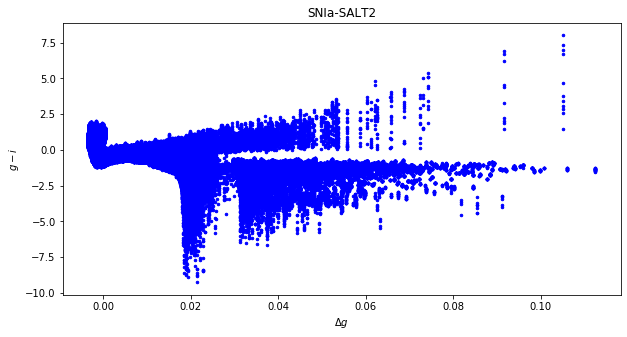

In [155]:
Thr = 30

fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

for II in range(len(Interp_load[Band1])): 
    
    TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
    TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )
    
    TimeRange = TimeRangeEnd - TimeRangeStart
    SampleNo = np.int(PointsPDay*TimeRange)
        
    XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
    
    Mag1 = Interp_load[Band1][II](XX)
    Mag2 = Interp_load[Band2][II](XX+dT1/1440)
    Mag12 = Interp_load[Band1][II](XX+dT2/1440)
    
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)
    
    ax.plot(Mag1[Mask] - Mag12[Mask], Mag1[Mask] - Mag2[Mask], '.', c = 'b', markersize=5)

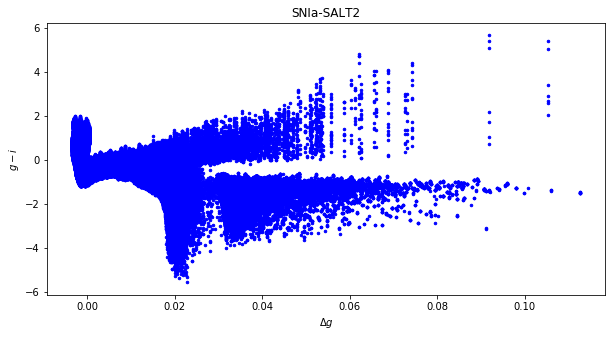

In [156]:
Thr = 25

fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

for II in range(len(Interp_load[Band1])): 
    
    TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
    TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )
    
    TimeRange = TimeRangeEnd - TimeRangeStart
    SampleNo = np.int(PointsPDay*TimeRange)
        
    XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
    
    Mag1 = Interp_load[Band1][II](XX)
    Mag2 = Interp_load[Band2][II](XX+dT1/1440)
    Mag12 = Interp_load[Band1][II](XX+dT2/1440)
    
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)
    
    ax.plot(Mag1[Mask] - Mag12[Mask], Mag1[Mask] - Mag2[Mask], '.', c = 'b', markersize=5)

In [288]:
EventNames = ['SNIa-SALT2', 'TDE']
PathInterpP1Day = '/global/homes/l/lianming/data/P1Day_Interp'
PathInterp2Day = '/global/homes/l/lianming/data/2Day_Interp'



#Parameter setting
PathInterp = PathInterp2Day
EventName = 'TDE'

Band1 = 'g'
Band2 = 'i'

dT2 = 30 #Time interval between the same band.
dT1 = 5 #Time interval between different bands.

PointsPDay = 5



Path = os.path.join(PathInterp, EventName+'_Interp.pkl')

with open(Path, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)    

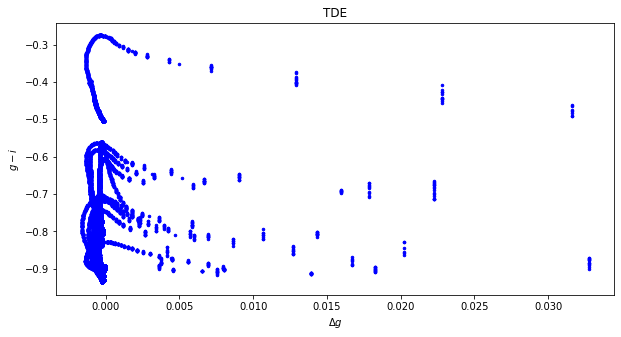

In [291]:
Thr = 30

fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
ax.set_title(EventName)

for II in range(45,55): 
    
    TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
    TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )
    
    TimeRange = TimeRangeEnd - TimeRangeStart
    SampleNo = np.int(PointsPDay*TimeRange)
        
    XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
    
    Mag1 = Interp_load[Band1][II](XX)
    Mag2 = Interp_load[Band2][II](XX+dT1/1440)
    Mag12 = Interp_load[Band1][II](XX+dT2/1440)
    
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)
    
    ax.plot(Mag1[Mask] - Mag12[Mask], Mag1[Mask] - Mag2[Mask], '.', c = 'b', markersize=5)

In [108]:
Path = '/global/homes/l/lianming/data/Test_Interp1/KN_B19_Interp.pkl'

with open(Path, 'rb') as f:
    KN_load1 = pickle.load(f)
    TimeRange_load1 = pickle.load(f)

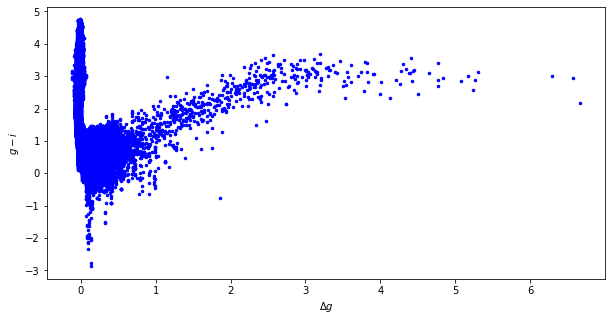

In [137]:
Thr = 30

fig, ax = plt.subplots(1, 1, figsize=[10,5])
ax.set_xlabel("$\Delta {0}$".format(Band1), fontsize=10)
ax.set_ylabel('${0}-{1}$'.format(Band1,Band2), fontsize=10)
# ax.set_xlim([-0.2, 1.4])

for II in range(len(KN_load1[Band1])):
#     np.random.seed(123)
    XX = np.random.rand(1000)*(TimeRange_load1[1] - TimeRange_load1[0] - max(dT1, dT2)/1440) + TimeRange_load1[0]
    
    Mag1 = KN_load1[Band1][II](XX)
    Mag2 = KN_load1[Band2][II](XX+dT1/1440)
    Mag12 = KN_load1[Band1][II](XX+dT2/1440)
    
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)
    
    ax.plot(Mag1[Mask] - Mag12[Mask], Mag1[Mask] - Mag2[Mask], '.', c = 'b', markersize=5)
    
    

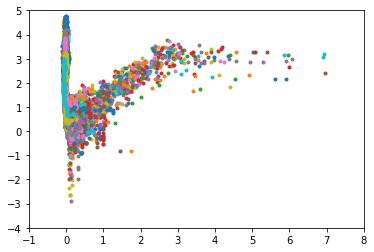

In [125]:
Thr = 30

fig, ax = plt.subplots(1, 1)
ax.set_xlim([-1, 8])
ax.set_ylim([-4, 5])

for II in range(len(KN_load['g'])):
    XX = np.random.rand(1000)*(TimeRange_load[1] - TimeRange_load[0] - max(dT1, dT2)/1440) + TimeRange_load[0]
    
    MagG = KN_load['g'][II](XX)
    MagI = KN_load['i'][II](XX+dT1/1440)
    MagG2 = KN_load['g'][II](XX+dT2/1440)
    
    Mask = (MagG<Thr) * (MagI<Thr) *(MagG2<Thr)
    
    ax.plot(MagG[Mask] - MagG2[Mask], MagG[Mask] - MagI[Mask], '.')
    
    

In [1]:
pip install astroML --user

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from astroML import plotting

([0], [57, 87, 158, 163, 189, 191, 192, 193, 194])

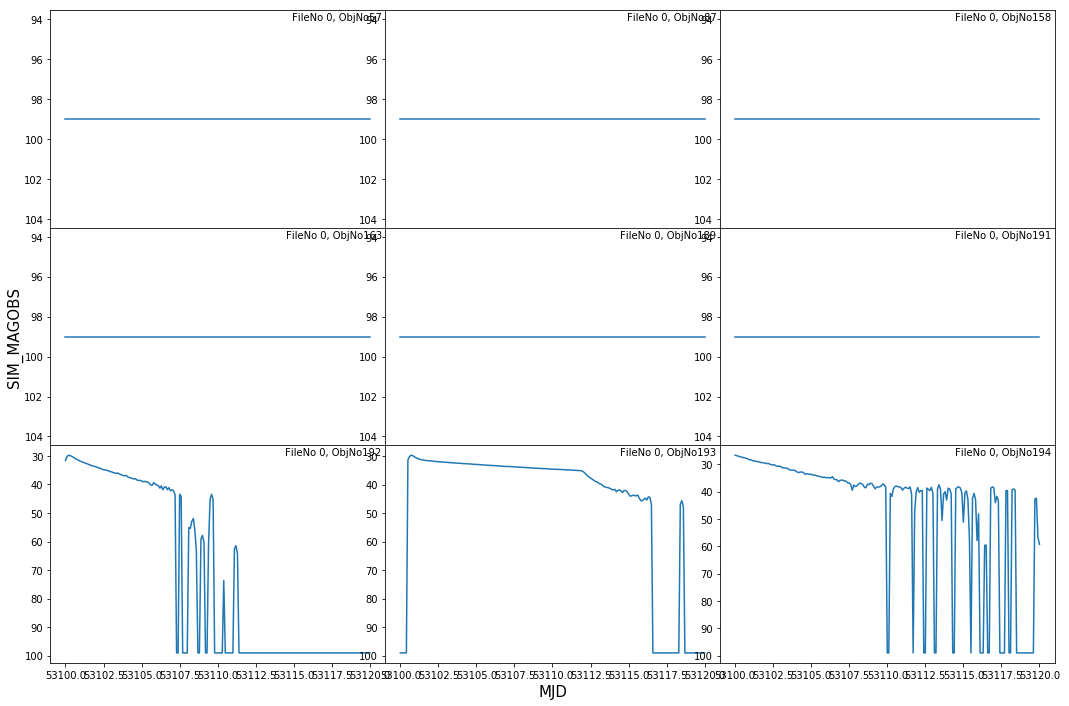

In [22]:
Functions.PlotLightCurve(Path1, 'KN_K17', 'u', FileNo=[0], ObjNo=[57, 87, 158, 163, 189, 191, 192, 193, 194])

In [157]:
Path = '/global/homes/l/lianming/data/Test_Interp'

In [158]:
Functions.PlotLightCurve(Path1, EventName, 'u ')

The band input does not exist.


In [21]:
data = CalculateMap(Path, 'TDE', 'g', 'i', 5 , 30)

FileNotFoundError: [Errno 2] No such file or directory: '/global/homes/l/lianming/data/For_Test/TDE_Interp.pkl'

In [22]:
dT1s = np.arange(-60, 61, 30)
dT2s = np.arange(120, 241, 30)
Binx = np.arange(-4.75, 5, 0.5)
Biny = np.arange(-3.25, 7, 0.5)

In [23]:
dT1s

array([-60, -30,   0,  30,  60])

In [24]:
abs( 20 - dT1s )

array([80, 50, 20, 10, 40])

In [26]:
abs( 20 - dT1s ).argmin()

3

In [27]:
np.arange(-3.25, 7, 0.5)

array([-3.25, -2.75, -2.25, -1.75, -1.25, -0.75, -0.25,  0.25,  0.75,
        1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,  4.75,  5.25,
        5.75,  6.25,  6.75])

In [32]:
Binx = np.arange(-4.75, 5, 0.5)

In [33]:
Binx

array([-4.75, -4.25, -3.75, -3.25, -2.75, -2.25, -1.75, -1.25, -0.75,
       -0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,
        4.25,  4.75])

In [ ]:
xx = [ ii

In [35]:
mean(1.3, 1.6)

NameError: name 'mean' is not defined

In [36]:
(Binx[:-1]+Binx[1:])/2

array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])

In [37]:
def BandInNo(Band):
    BandDict = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'Y': 5}
    return BandDict[Band]    

In [39]:
def BandInNo2(Band):
    Bands = ['u', 'g', 'r', 'i', 'z', 'Y']
    return BandDict[Band]    

KeyError: 'o'

In [40]:
Bands = ['u', 'g', 'r', 'i', 'z', 'Y']

In [42]:
[ii == 'u' for ii in Bands]

[True, False, False, False, False, False]

In [44]:
np.where([ii == 'Y' for ii in Bands])

(array([5]),)

In [45]:
Bands.index('Y')

5

In [55]:
Functions.BandInNo('o')

Wrong bands input! The available bands are:
['u', 'g', 'r', 'i', 'z', 'Y']
